In [3]:
import os
from google.colab import drive
drive.mount('/content/driv\e', force_remount=True)
root_path = os.path.join(os.getcwd(), "drive", "My Drive/mnist") # replace based on your Google drive organization
dataset_path = os.path.join(root_path, "data") # same here

TIMEOUT: ignored

In [ ]:
from scipy.special import softmax
from tqdm import tqdm
from matplotlib import pyplot as plt
import os
import numpy as np
import numpy
import scipy
import matplotlib
import mnist
import pickle
# matplotlib.use('agg')
import time

ModuleNotFoundError: ignored

In [ ]:
# mnist_data_directory = os.path.join(os.path.dirname(__file__), "data")
mnist_data_directory = "data"

In [ ]:
def load_MNIST_dataset():
    PICKLE_FILE = os.path.join(mnist_data_directory, "MNIST.pickle")
    try:
        dataset = pickle.load(open(PICKLE_FILE, 'rb'))
    except:
        # load the MNIST dataset
        mnist_data = mnist.MNIST(mnist_data_directory, return_type="numpy", gz=True)
        Xs_tr, Lbls_tr = mnist_data.load_training();
        Xs_tr = Xs_tr.transpose() / 255.0
        Ys_tr = numpy.zeros((10, 60000))
        for i in range(60000):
            Ys_tr[Lbls_tr[i], i] = 1.0  # one-hot encode each label
        Xs_tr = numpy.ascontiguousarray(Xs_tr)
        Ys_tr = numpy.ascontiguousarray(Ys_tr)
        Xs_te, Lbls_te = mnist_data.load_testing();
        Xs_te = Xs_te.transpose() / 255.0
        Ys_te = numpy.zeros((10, 10000))
        for i in range(10000):
            Ys_te[Lbls_te[i], i] = 1.0  # one-hot encode each label
        Xs_te = numpy.ascontiguousarray(Xs_te)
        Ys_te = numpy.ascontiguousarray(Ys_te)
        dataset = (Xs_tr, Ys_tr, Xs_te, Ys_te)
        pickle.dump(dataset, open(PICKLE_FILE, 'wb'))
    return dataset



In [ ]:
mnist = load_MNIST_dataset()

In [ ]:
print(mnist[3])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
x_train = mnist[0]
y_train = mnist[1]
x_test = mnist[2]
y_test = mnist[3]

## 2 helper functions

In [ ]:
# compute the gradient of the multinomial logistic regression objective, with regularization
#
# Xs        training examples (d * n)
# Ys        training labels   (c * n)
# ii        the list/vector of indexes of the training example to compute the gradient with respect to
# gamma     L2 regularization constant
# W         parameters        (c * d)
#
# returns   the average gradient of the regularized loss of the examples in vector ii with respect to the model parameters
def multinomial_logreg_grad_i(Xs, Ys, ii, gamma, W):
    # TODO students should implement this
    Xbatch = Xs[: , ii]
    Ybatch = Ys[: , ii]
    

    n = len(ii)
    yhat = softmax(np.matmul(W,Xbatch))
    
    left = (yhat-Ybatch)
    xT = Xbatch.T
    
    grad_matrix = np.matmul(left,xT)
    
    grad_matrix /= n
    grad_matrix += gamma * W
    
    return grad_matrix

In [ ]:
def multinomial_logreg_error(Xs, Ys, W):
    # TODO students should use their implementation from programming assignment 1
    h = softmax(W.dot(Xs))
    return numpy.sum(numpy.argmax(h, axis=0) != numpy.argmax(Ys, axis=0)) / len(Xs[0])

In [ ]:
# compute the error of the classifier
#
# Xs        examples          (d * n)
# Ys        labels            (c * n)
# W         parameters        (c * d)
#
# returns   the model error as a percentage of incorrect labels


def multinomial_logreg_error(Xs, Ys, W):
    (_, n) = Xs.shape
    y_pred = np.argmax(np.matmul(W,Xs), axis = 0)
    y_true = np.argmax(Ys, axis= 0)
    false_pred = np.count_nonzero((y_pred - y_true), axis =0)
    err_rate = false_pred / n
    return err_rate

### Testing helper function

In [ ]:
ind = [0,1,2,3,4,5]

In [ ]:
multinomial_logreg_grad_i(x_train, y_train, ind, 0.0001, np.zeros([10,784]))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Algorithms

In [ ]:
# ALGORITHM 1: run stochastic gradient descent on a multinomial logistic regression objective, with regularization
#
# Xs              training examples (d * n)
# Ys              training labels   (c * n)
# gamma           L2 regularization constant
# W0              the initial value of the parameters (c * d)
# alpha           step size/learning rate
# num_epochs      number of epochs (passes through the training set) to run
# monitor_period  how frequently, in terms of iterations (not epochs) to output the parameter vector
#
# returns         a list of model parameters, one every "monitor_period" iterations
def stochastic_gradient_descent(Xs, Ys, gamma, W0, alpha, num_epochs, monitor_period):
    # TODO students should implement this
    output=[]
    output.append(W0.copy())
    
    
    (_, n) = Xs.shape
    T = num_epochs * n
    for i in range(T):
        rand_ind = np.random.randint(0, n, 1)
        diff = -alpha * multinomial_logreg_grad_i(Xs, Ys, rand_ind, gamma, W0)
        W0 += diff

        if (i % monitor_period == 0 and i != 0) or i == num_epochs-1:
            output.append(W0.copy())
    return output

In [ ]:

# ALGORITHM 2: run stochastic gradient descent with sequential sampling order
#
# Xs              training examples (d * n)
# Ys              training labels   (c * n)
# gamma           L2 regularization constant
# W0              the initial value of the parameters (c * d)
# alpha           step size/learning rate
# num_epochs      number of epochs (passes through the training set) to run
# monitor_period  how frequently, in terms of iterations (not epochs) to output the parameter vector
#
# returns         a list of model parameters, one every "monitor_period" iterations
def sgd_sequential_scan(Xs, Ys, gamma, W0, alpha, num_epochs, monitor_period):
    # TODO students should implement this
    output=[]
    output.append(W0.copy())
    
    (_, n) = Xs.shape
    
    iteration = 0
    
    for t in range(num_epochs):
        for i in range(n):
            
            diff = -alpha * multinomial_logreg_grad_i(Xs, Ys, [i], gamma, W0)
            W0 += diff
            if (iteration % monitor_period == 0 and i != 0) or i == num_epochs-1:
                output.append(W0.copy())
            iteration +=1
    return output



In [ ]:
# ALGORITHM 3: run stochastic gradient descent with minibatching
#
# Xs              training examples (d * n)
# Ys              training labels   (c * n)
# gamma           L2 regularization constant
# W0              the initial value of the parameters (c * d)
# alpha           step size/learning rate
# B               minibatch size
# num_epochs      number of epochs (passes through the training set) to run
# monitor_period  how frequently, in terms of batches (not epochs) to output the parameter vector
#
# returns         a list of model parameters, one every "monitor_period" batches
def sgd_minibatch(Xs, Ys, gamma, W0, alpha, B, num_epochs, monitor_period):
    # TODO students should implement this
    output=[]
    output.append(W0.copy())
    
    
    (_, n) = Xs.shape
    T = int(num_epochs * n / B)
    
    batch_number = 0


    for t in range(T):
        batch = []
        for b in range(B):
            batch.append(np.random.randint(0, n))
        
        sum_weight = np.zeros(W0.shape)
        for i in batch:
            sum_weight += multinomial_logreg_grad_i(Xs, Ys, [i], gamma, W0)
        
        sum_weight/=B

        W0 -= alpha * sum_weight
        if (batch_number % monitor_period == 0 and i != 0) or i == num_epochs-1:
            output.append(W0.copy())
        batch_number +=1
    return output

In [ ]:
# ALGORITHM 4: run stochastic gradient descent with minibatching and sequential sampling order
#
# Xs              training examples (d * n)
# Ys              training labels   (c * n)
# gamma           L2 regularization constant
# W0              the initial value of the parameters (c * d)
# alpha           step size/learning rate
# B               minibatch size
# num_epochs      number of epochs (passes through the training set) to run
# monitor_period  how frequently, in terms of batches (not epochs) to output the parameter vector
#
# returns         a list of model parameters, one every "monitor_period" batches
def sgd_minibatch_sequential_scan(Xs, Ys, gamma, W0, alpha, B, num_epochs, monitor_period):
    # TODO students should implement this
    output=[]
    output.append(W0.copy())
    
    
    (_, n) = Xs.shape    
    batch_number = 0


    for t in range(num_epochs):
        for i in range(int(n/B - 1)):
            batch = np.arange(i*B,(i+1)*B)
            sum_weight = np.zeros(W0.shape)
            for i in batch:
                sum_weight += multinomial_logreg_grad_i(Xs, Ys, [i], gamma, W0)

            sum_weight/=B

            W0 -= alpha * sum_weight
            if (batch_number % monitor_period == 0 and i != 0) or i == num_epochs-1:
                output.append(W0.copy())
            batch_number +=1
    return output

## Plots

In [ ]:
W = np.zeros([10,784])

In [ ]:
# Train

In [ ]:
start_time = time.time()
vanilla_sgd_weights = stochastic_gradient_descent(x_train, y_train, 0.0001, np.zeros([10,784]), 0.001, 10, 6000)
print("--- %s seconds ---" % (time.time() - start_time))

--- 81.13409113883972 seconds ---


In [ ]:
start_time = time.time()
sequential_sgd_weights = sgd_sequential_scan(x_train, y_train, 0.0001, np.zeros([10,784]), 0.001, 10, 6000)
print("--- %s seconds ---" % (time.time() - start_time))

--- 58.263587951660156 seconds ---


In [ ]:
start_time = time.time()
minibatch_sgd_weights = sgd_minibatch(x_train, y_train, 0.0001, np.zeros([10,784]), 0.05, 60, 10, 100)
print("--- %s seconds ---" % (time.time() - start_time))

--- 68.34401082992554 seconds ---


In [ ]:
start_time = time.time()
sequential_minibatch_sgd_weights = sgd_minibatch_sequential_scan(x_train, y_train, 0.0001, np.zeros([10,784]), 0.05, 60, 10, 100)
print("--- %s seconds ---" % (time.time() - start_time))

--- 56.19468688964844 seconds ---


In [ ]:
print(len(sequential_minibatch_sgd_weights))
print(len(minibatch_sgd_weights))

101
101


In [ ]:
def gen_coords(weights):
    training_error = []
    for i in range(len(weights))[0::1]:
#     for i in range(len(weights)):
        epoch = i/10
        training_error.append((epoch, multinomial_logreg_error(x_train, y_train, weights[i])))
    training_error = np.array([numpy.array(xi) for xi in training_error])
    x = training_error[:,0]
    y = training_error[:,1]
    
    return x,y

In [ ]:
# Train

In [ ]:
x, vanilla_sgd_y = gen_coords(vanilla_sgd_weights)
_, sequential_sgd_y = gen_coords(sequential_sgd_weights)
_, minibatch_sgd_y = gen_coords(minibatch_sgd_weights)
_, sequential_minibatch_sgd_y = gen_coords(sequential_minibatch_sgd_weights)

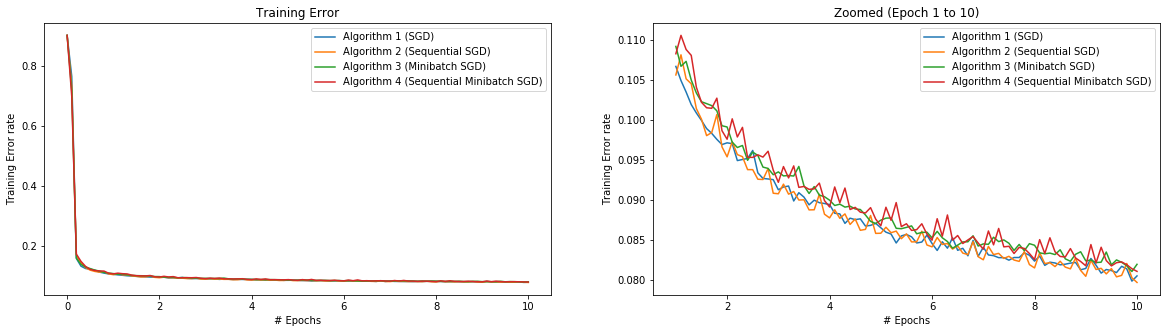

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)

plt.plot(x, vanilla_sgd_y, label = "Algorithm 1 (SGD)")
plt.plot(x, sequential_sgd_y, label = "Algorithm 2 (Sequential SGD)")
plt.plot(x, minibatch_sgd_y, label = "Algorithm 3 (Minibatch SGD)")
plt.plot(x, sequential_minibatch_sgd_y, label = "Algorithm 4 (Sequential Minibatch SGD)")

plt.legend()
plt.title("Training Error")
plt.xlabel("# Epochs")
plt.ylabel("Training Error rate")

plt.subplot(1, 2, 2)


plt.plot(x[10:], vanilla_sgd_y[10:], label = "Algorithm 1 (SGD)")
plt.plot(x[10:], sequential_sgd_y[10:], label = "Algorithm 2 (Sequential SGD)")
plt.plot(x[10:], minibatch_sgd_y[10:], label = "Algorithm 3 (Minibatch SGD)")
plt.plot(x[10:], sequential_minibatch_sgd_y[10:], label = "Algorithm 4 (Sequential Minibatch SGD)")

plt.legend()
plt.title("Zoomed (Epoch 1 to 10)")
plt.xlabel("# Epochs")
plt.ylabel("Training Error rate")
plt.show()

In [ ]:
# Test

In [ ]:
def gen_coords_testset(weights):
    test_error = []
    for i in range(len(weights))[0::1]:
#     for i in range(len(weights)):
        epoch = i/10
        test_error.append((epoch, multinomial_logreg_error(x_test, y_test, weights[i])))
    test_error = np.array([numpy.array(xi) for xi in test_error])
    x = test_error[:,0]
    y = test_error[:,1]
    
    return x,y

In [ ]:
x, test_vanilla_sgd_y = gen_coords_testset(vanilla_sgd_weights)
_, test_sequential_sgd_y = gen_coords_testset(sequential_sgd_weights)
_, test_minibatch_sgd_y = gen_coords_testset(minibatch_sgd_weights)
_, test_sequential_minibatch_sgd_y = gen_coords_testset(sequential_minibatch_sgd_weights)

### Test error from epoch 0 to epoch 10

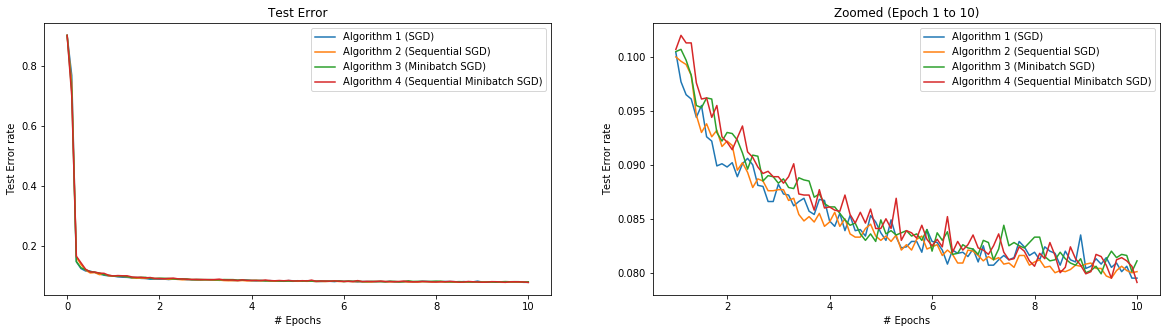

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)


plt.plot(x, test_vanilla_sgd_y, label = "Algorithm 1 (SGD)")
plt.plot(x, test_sequential_sgd_y, label = "Algorithm 2 (Sequential SGD)")
plt.plot(x, test_minibatch_sgd_y, label = "Algorithm 3 (Minibatch SGD)")
plt.plot(x, test_sequential_minibatch_sgd_y, label = "Algorithm 4 (Sequential Minibatch SGD)")
plt.legend()

plt.title("Test Error")
plt.xlabel("# Epochs")
plt.ylabel("Test Error rate")

plt.subplot(1, 2, 2)

plt.plot(x[10:], test_vanilla_sgd_y[10:], label = "Algorithm 1 (SGD)")
plt.plot(x[10:], test_sequential_sgd_y[10:], label = "Algorithm 2 (Sequential SGD)")
plt.plot(x[10:], test_minibatch_sgd_y[10:], label = "Algorithm 3 (Minibatch SGD)")
plt.plot(x[10:], test_sequential_minibatch_sgd_y[10:], label = "Algorithm 4 (Sequential Minibatch SGD)")
plt.legend()

plt.title("Zoomed (Epoch 1 to 10)")
plt.xlabel("# Epochs")
plt.ylabel("Test Error rate")
plt.show()



# Part 2

In [ ]:
W = np.zeros([10,784])
vanilla_sgd_0_0_5 = stochastic_gradient_descent(x_train, y_train, 0.0001, W, 0.005, 10, 6000)

In [ ]:
W = np.zeros([10,784])
vanilla_sgd_0_1 = stochastic_gradient_descent(x_train, y_train, 0.0001, W, 0.01, 10, 6000)

In [ ]:
W = np.zeros([10,784])
vanilla_sgd_0_3 = stochastic_gradient_descent(x_train, y_train, 0.0001, W, 0.03, 10, 6000)

In [ ]:
W = np.zeros([10,784])
vanilla_sgd_0_0_0_1 = stochastic_gradient_descent(x_train, y_train, 0.0001, W, 0.0001, 10, 6000)

In [ ]:
x, vanilla_sgd_y = gen_coords(vanilla_sgd_weights)
_, vanilla_sgd_y2 = gen_coords(vanilla_sgd_0_1)
_, vanilla_sgd_y3 = gen_coords(vanilla_sgd_0_0_5)
_, vanilla_sgd_y4 = gen_coords(vanilla_sgd_0_0_0_1)
_, vanilla_sgd_y5 = gen_coords(vanilla_sgd_0_3)

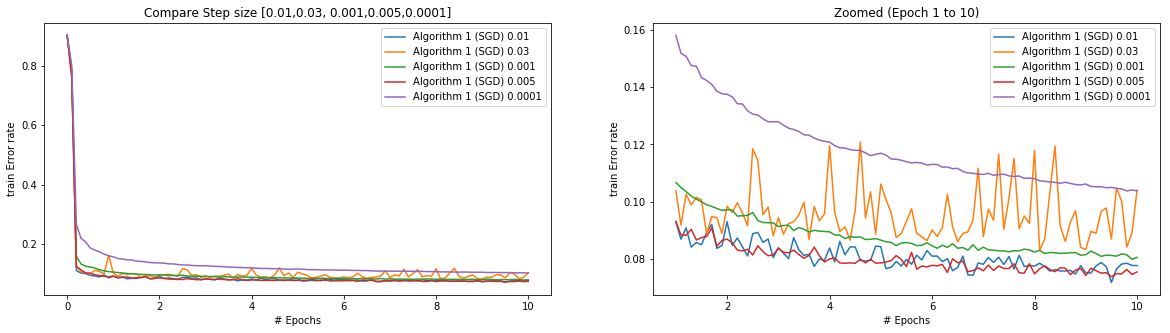

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)


plt.plot(x, vanilla_sgd_y2, label = "Algorithm 1 (SGD) 0.01")
plt.plot(x, vanilla_sgd_y5, label = "Algorithm 1 (SGD) 0.03")
plt.plot(x, vanilla_sgd_y, label = "Algorithm 1 (SGD) 0.001")
plt.plot(x, vanilla_sgd_y3, label = "Algorithm 1 (SGD) 0.005")
plt.plot(x, vanilla_sgd_y4, label = "Algorithm 1 (SGD) 0.0001")
plt.legend()

plt.title("Compare Step size [0.01,0.03, 0.001,0.005,0.0001]")
plt.xlabel("# Epochs")
plt.ylabel("train Error rate")

plt.subplot(1, 2, 2)
plt.plot(x[10:], vanilla_sgd_y2[10:], label = "Algorithm 1 (SGD) 0.01")
plt.plot(x[10:], vanilla_sgd_y5[10:], label = "Algorithm 1 (SGD) 0.03")
plt.plot(x[10:], vanilla_sgd_y[10:], label = "Algorithm 1 (SGD) 0.001")
plt.plot(x[10:], vanilla_sgd_y3[10:], label = "Algorithm 1 (SGD) 0.005")
plt.plot(x[10:], vanilla_sgd_y4[10:], label = "Algorithm 1 (SGD) 0.0001")
plt.legend()

plt.title("Zoomed (Epoch 1 to 10)")
plt.xlabel("# Epochs")
plt.ylabel("train Error rate")

plt.show()

In [ ]:
x, vanilla_sgd_y_test = gen_coords_testset(vanilla_sgd_weights)
_, vanilla_sgd_y2_test = gen_coords_testset(vanilla_sgd_0_1)
_, vanilla_sgd_y3_test = gen_coords_testset(vanilla_sgd_0_0_5)
_, vanilla_sgd_y4_test = gen_coords_testset(vanilla_sgd_0_0_0_1)
_, vanilla_sgd_y5_test = gen_coords_testset(vanilla_sgd_0_3)

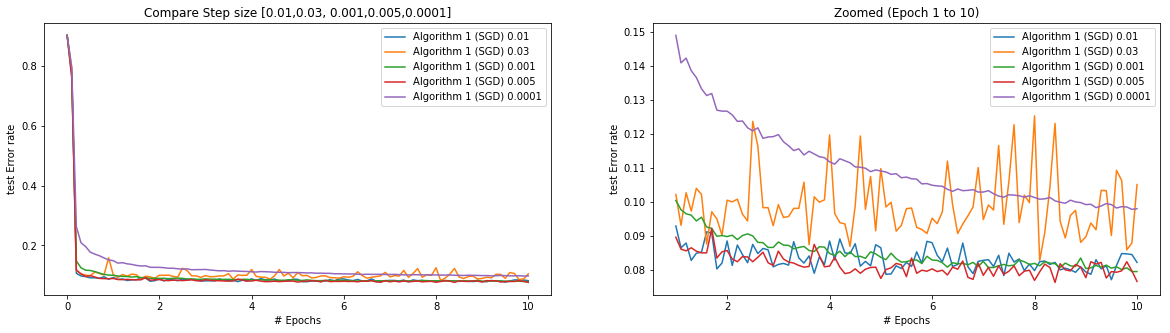

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)


plt.plot(x, vanilla_sgd_y2_test, label = "Algorithm 1 (SGD) 0.01")
plt.plot(x, vanilla_sgd_y5_test, label = "Algorithm 1 (SGD) 0.03")
plt.plot(x, vanilla_sgd_y_test, label = "Algorithm 1 (SGD) 0.001")
plt.plot(x, vanilla_sgd_y3_test, label = "Algorithm 1 (SGD) 0.005")
plt.plot(x, vanilla_sgd_y4_test, label = "Algorithm 1 (SGD) 0.0001")
plt.legend()

plt.title("Compare Step size [0.01,0.03, 0.001,0.005,0.0001]")
plt.xlabel("# Epochs")
plt.ylabel("test Error rate")

plt.subplot(1, 2, 2)


plt.plot(x[10:], vanilla_sgd_y2_test[10:], label = "Algorithm 1 (SGD) 0.01")
plt.plot(x[10:], vanilla_sgd_y5_test[10:], label = "Algorithm 1 (SGD) 0.03")
plt.plot(x[10:], vanilla_sgd_y_test[10:], label = "Algorithm 1 (SGD) 0.001")
plt.plot(x[10:], vanilla_sgd_y3_test[10:], label = "Algorithm 1 (SGD) 0.005")
plt.plot(x[10:], vanilla_sgd_y4_test[10:], label = "Algorithm 1 (SGD) 0.0001")
plt.legend()

plt.title("Zoomed (Epoch 1 to 10)")
plt.xlabel("# Epochs")
plt.ylabel("test Error rate")
plt.show()

Part 2.1 & 2.2
> We compare different learning rate from [0.01,0.03, 0.001,0.005,0.0001], we found the best and most stable learning rate is **0.005**. The step size of 0,005 (the red line) reach the lowest training error after 10 epochs and it is below the training error of step size 0.001(the green line). The major take away from the graph are: 
*   a)  A larger learning rate (the blue line, 0.01) will result in great changes in gradient; it is running faster but fluctuating around the optimal solution. 
*   b) A lower learning rate (the purple line, 0.0001) will result in minimal changes in gradient; it is running much slower but converge process is smooth.
*   c) The test error plot is almost the same tendency as train error plot. The step size of 0.005 is still the optimal learning rate and above the original step size 0.001. And we can see the line of learning rate 0.01 (blue) is above the line of learning rate 0.005 (red) after 10 epochs, which means although a large learning rate may hit the same train error during the training process, it cannot gurantee the same performance during testing process, instead the smoother red line (0.005) can achieve the best testing result.

Part 2.3
>  Both blue (0.01) and red (0.005) line allow the algorithm to reach better training error after 5 epochs than could be achieved in 10 epochs using the step size 0.001. After 5 epochs, the test error for both blue (0.01) and red (0.05) are almost the same, and both results are below the orignal testing result. As we increase the step size, the model converges faster, but the test error rate varies. It seems like the blue (0.01) line converges to a noise ball. However, a learning rate like the red (0.005) is better because it is larger enought to jump out of the local minimal and converge faster than the orignal step size 0.001. So we want to set the step size larger for directions with less curvature, and smaller for directions with more curvature.









In [ ]:
W = np.zeros([10,784])
sequential_minibatch_0_1 = sgd_minibatch_sequential_scan(x_train, y_train, 0.0001, W, 0.01, 60, 10, 100)



In [ ]:
W = np.zeros([10,784])
sequential_minibatch_1 = sgd_minibatch_sequential_scan(x_train, y_train, 0.0001, W, 0.1, 60, 10, 100)

In [ ]:
W = np.zeros([10,784])
sequential_minibatch_0_0_5 = sgd_minibatch_sequential_scan(x_train, y_train, 0.0001, W, 0.005, 60, 10, 100)

In [ ]:
W = np.zeros([10,784])
sequential_minibatch_5 = sgd_minibatch_sequential_scan(x_train, y_train, 0.0001, W, 0.5, 60, 10, 100)

In [ ]:
W = np.zeros([10,784])
sequential_minibatch_600 = sgd_minibatch_sequential_scan(x_train, y_train, 0.0001, W, 0.05, 600, 10, 10)

In [ ]:
W = np.zeros([10,784])
sequential_minibatch_30 = sgd_minibatch_sequential_scan(x_train, y_train, 0.0001, W, 0.05, 30, 10, 200)

In [ ]:
W = np.zeros([10,784])
sequential_minibatch_120 = sgd_minibatch_sequential_scan(x_train, y_train, 0.0001, W, 0.05, 120, 10, 50)

In [ ]:
x, seq_mini_y = gen_coords(sequential_minibatch_sgd_weights)#0.05
_, seq_mini_y2 = gen_coords(sequential_minibatch_0_1)
_, seq_mini_y3 = gen_coords(sequential_minibatch_5)
_, seq_mini_y4 = gen_coords(sequential_minibatch_0_0_5)
_, seq_mini_y5 = gen_coords(sequential_minibatch_1)

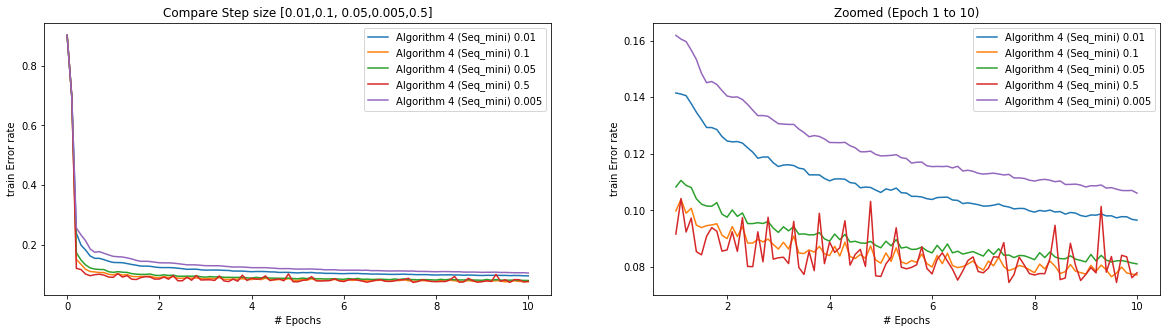

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)

plt.plot(x, seq_mini_y2, label = "Algorithm 4 (Seq_mini) 0.01")
plt.plot(x, seq_mini_y5, label = "Algorithm 4 (Seq_mini) 0.1")
plt.plot(x, seq_mini_y, label = "Algorithm 4 (Seq_mini) 0.05")
plt.plot(x, seq_mini_y3, label = "Algorithm 4 (Seq_mini) 0.5")
plt.plot(x, seq_mini_y4, label = "Algorithm 4 (Seq_mini) 0.005")
plt.legend()

plt.title("Compare Step size [0.01,0.1, 0.05,0.005,0.5]")
plt.xlabel("# Epochs")
plt.ylabel("train Error rate")

plt.subplot(1, 2, 2)

plt.plot(x[10:], seq_mini_y2[10:], label = "Algorithm 4 (Seq_mini) 0.01")
plt.plot(x[10:], seq_mini_y5[10:], label = "Algorithm 4 (Seq_mini) 0.1")
plt.plot(x[10:], seq_mini_y[10:], label = "Algorithm 4 (Seq_mini) 0.05")
plt.plot(x[10:], seq_mini_y3[10:], label = "Algorithm 4 (Seq_mini) 0.5")
plt.plot(x[10:], seq_mini_y4[10:], label = "Algorithm 4 (Seq_mini) 0.005")
plt.legend()

plt.title("Zoomed (Epoch 1 to 10)")
plt.xlabel("# Epochs")
plt.ylabel("train Error rate")
plt.show()

In [ ]:
x, seq_mini_y_test = gen_coords_testset(sequential_minibatch_sgd_weights)#0.05
_, seq_mini_y2_test = gen_coords_testset(sequential_minibatch_0_1)
_, seq_mini_y3_test = gen_coords_testset(sequential_minibatch_0_0_5)
_, seq_mini_y4_test = gen_coords_testset(sequential_minibatch_5)
_, seq_mini_y5_test = gen_coords_testset(sequential_minibatch_1)

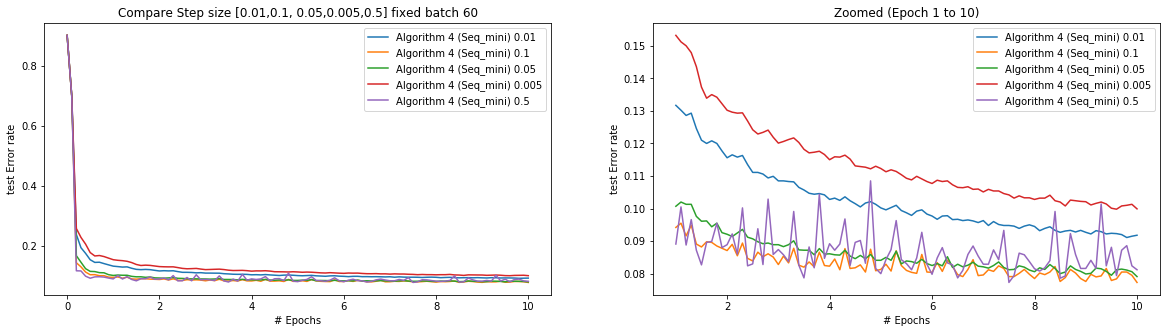

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)

plt.plot(x, seq_mini_y2_test, label = "Algorithm 4 (Seq_mini) 0.01")
plt.plot(x, seq_mini_y5_test, label = "Algorithm 4 (Seq_mini) 0.1")
plt.plot(x, seq_mini_y_test, label = "Algorithm 4 (Seq_mini) 0.05")
plt.plot(x, seq_mini_y3_test, label = "Algorithm 4 (Seq_mini) 0.005")
plt.plot(x, seq_mini_y4_test, label = "Algorithm 4 (Seq_mini) 0.5")
plt.legend()

plt.title("Compare Step size [0.01,0.1, 0.05,0.005,0.5] fixed batch 60")
plt.xlabel("# Epochs")
plt.ylabel("test Error rate")

plt.subplot(1, 2, 2)

plt.plot(x[10:], seq_mini_y2_test[10:], label = "Algorithm 4 (Seq_mini) 0.01")
plt.plot(x[10:], seq_mini_y5_test[10:], label = "Algorithm 4 (Seq_mini) 0.1")
plt.plot(x[10:], seq_mini_y_test[10:], label = "Algorithm 4 (Seq_mini) 0.05")
plt.plot(x[10:], seq_mini_y3_test[10:], label = "Algorithm 4 (Seq_mini) 0.005")
plt.plot(x[10:], seq_mini_y4_test[10:], label = "Algorithm 4 (Seq_mini) 0.5")
plt.legend()

plt.title("Zoomed (Epoch 1 to 10)")
plt.xlabel("# Epochs")
plt.ylabel("test Error rate")
plt.show()

In [ ]:
x, seq_mini_y_60 = gen_coords(sequential_minibatch_sgd_weights)
_, seq_mini_y2_120 = gen_coords(sequential_minibatch_120)
_, seq_mini_y3_600 = gen_coords(sequential_minibatch_600)
_, seq_mini_y4_30 = gen_coords(sequential_minibatch_30)
#_, seq_mini_y5 = gen_coords(sequential_minibatch_0_3)

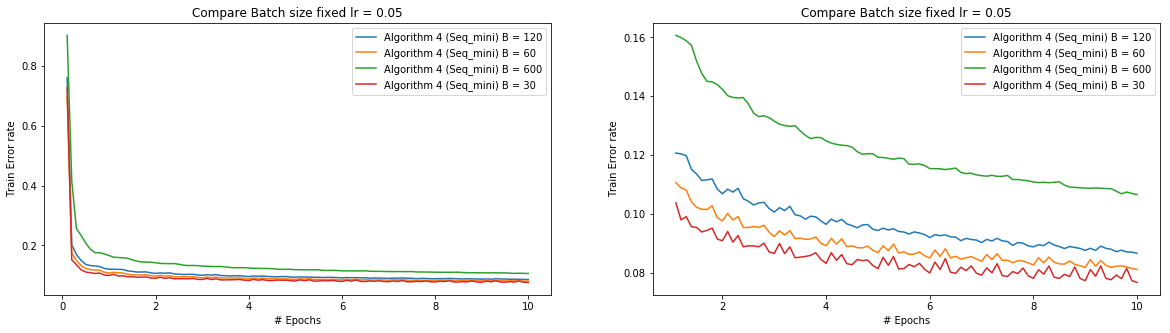

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)



plt.plot(x[1:], seq_mini_y2_120[1:], label = "Algorithm 4 (Seq_mini) B = 120")
#plt.plot(x, seq_mini_y5_test, label = "Algorithm 4 (Seq_mini) 0.03")
plt.plot(x[1:], seq_mini_y_60[1:], label = "Algorithm 4 (Seq_mini) B = 60")
plt.plot(x[1:], seq_mini_y3_600, label = "Algorithm 4 (Seq_mini) B = 600")
plt.plot(x[1:], seq_mini_y4_30[1:], label = "Algorithm 4 (Seq_mini) B = 30")
plt.legend()

plt.title("Compare Batch size fixed lr = 0.05")
plt.xlabel("# Epochs")
plt.ylabel("Train Error rate")

plt.subplot(1, 2, 2)



plt.plot(x[11:], seq_mini_y2_120[11:], label = "Algorithm 4 (Seq_mini) B = 120")
#plt.plot(x, seq_mini_y5_test, label = "Algorithm 4 (Seq_mini) 0.03")
plt.plot(x[11:], seq_mini_y_60[11:], label = "Algorithm 4 (Seq_mini) B = 60")
plt.plot(x[11:], seq_mini_y3_600[10:], label = "Algorithm 4 (Seq_mini) B = 600")
plt.plot(x[11:], seq_mini_y4_30[11:], label = "Algorithm 4 (Seq_mini) B = 30")
plt.legend()

plt.title("Compare Batch size fixed lr = 0.05")
plt.xlabel("# Epochs")
plt.ylabel("Train Error rate")
plt.show()

In [ ]:
W = np.zeros([10,784])
sequential_minibatch_1_30 = sgd_minibatch_sequential_scan(x_train, y_train, 0.0001, W, 0.1, 30, 10, 200)

In [ ]:
print(len(sequential_minibatch_1_30))

101


In [ ]:
x, seq_mini_y_60_05 = gen_coords(sequential_minibatch_sgd_weights)
_, seq_mini_y2_30_5 = gen_coords(sequential_minibatch_1_30)



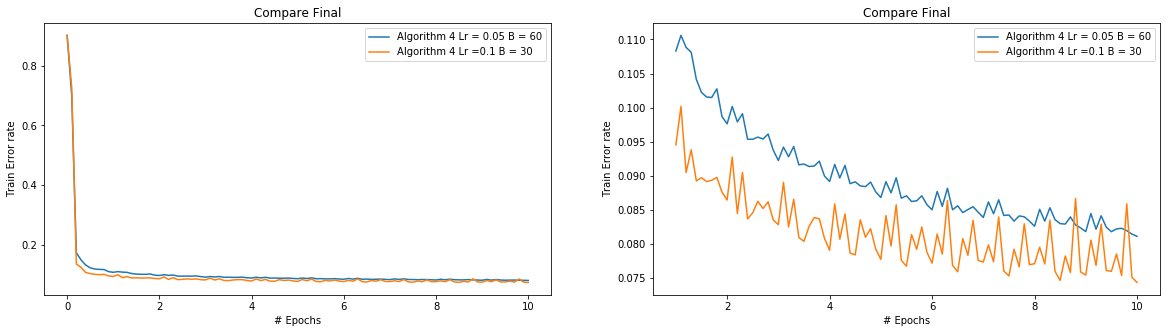

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)



plt.plot(x, seq_mini_y_60_05, label = "Algorithm 4 Lr = 0.05 B = 60")
plt.plot(x, seq_mini_y2_30_5, label = "Algorithm 4 Lr =0.1 B = 30")
plt.legend()

plt.title("Compare Final")
plt.xlabel("# Epochs")
plt.ylabel("Train Error rate")

plt.subplot(1, 2, 2)


plt.plot(x[10:], seq_mini_y_60_05[10:], label = "Algorithm 4 Lr = 0.05 B = 60")
plt.plot(x[10:], seq_mini_y2_30_5[10:], label = "Algorithm 4 Lr =0.1 B = 30")
plt.legend()

plt.title("Compare Final")
plt.xlabel("# Epochs")
plt.ylabel("Train Error rate")
plt.show()

In [ ]:

x, seq_mini_y_60_05_t = gen_coords_testset(sequential_minibatch_sgd_weights)
_, seq_mini_y2_30_5_t = gen_coords_testset(sequential_minibatch_1_30)

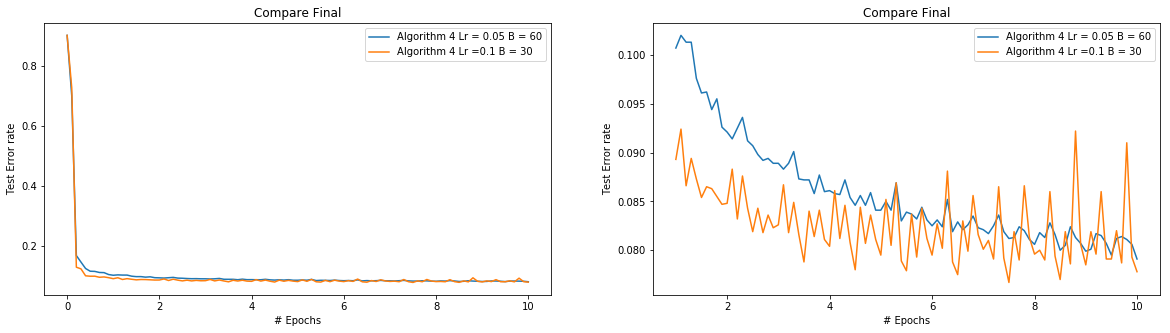

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)


plt.plot(x, seq_mini_y_60_05_t, label = "Algorithm 4 Lr = 0.05 B = 60")
plt.plot(x, seq_mini_y2_30_5_t, label = "Algorithm 4 Lr =0.1 B = 30")
plt.legend()

plt.title("Compare Final")
plt.xlabel("# Epochs")
plt.ylabel("Test Error rate")

plt.subplot(1, 2, 2)


plt.plot(x[10:], seq_mini_y_60_05_t[10:], label = "Algorithm 4 Lr = 0.05 B = 60")
plt.plot(x[10:], seq_mini_y2_30_5_t[10:], label = "Algorithm 4 Lr =0.1 B = 30")
plt.legend()

plt.title("Compare Final")
plt.xlabel("# Epochs")
plt.ylabel("Test Error rate")
plt.show()

**Part 2.4**
>We first compare the train error result for fixed batch size 60, we find the **best learning rate is 0.1**. Then we compare different batch size fixed the learning rate at 0.05, we find the **batch size of 30** can achieve the best result comparing with the batch size of 60. When we combine the learning rate of 0.1 and batch size 30, we can see the performance is still above the orignal one. The final test result for different learning rate is different here: 
*   In general, given fixed batch size, as we increase the step size, the performance of model is getting better with lower error rate; until the learning rate reach 0.5, which is too large, the purple line is fluctuating up and down. 
*   As we can tell from the graph, the test result for batch size 30 and lr 0.1 after 5 epochs is very unstable, which means it likely converges to a noise ball with high variance.



# Part 3